<a href="https://colab.research.google.com/github/dkalenov/bank-customer-churn-prediction/blob/main/Bank_customer_churn_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bank Churn Prediction

It is necessary to predict whether the client will leave the bank in the near future or not. We have historical data on customer behavior and termination of contracts with the bank.


### Description of [data](https://raw.githubusercontent.com/dkalenov/bank-customer-churn-prediction/main/Bank%20churn.csv)

- CustomerId — unique customer identifier

- Surname

- CreditScore - credit rating

- Geography - country of residence of the customer

- Gender

- Age

- Tenure - how many years the customer has already been cooperating with the bank

- Balance — balance on customer accounts

- NumOfProducts — number of open products in the bank

- HasCrCard — whether the customer has a bank credit card (0=No,1=Yes)

- IsActiveMember - active customer marker (whether often perform transactions) (0=No,1=Yes)

- EstimatedSalary - customer’s prediction income

- Exited—the fact that the customer left the bank (0=No,1=Yes)

Tasks:
1) Examine the data for problems (omissions/errors/incorrect).
2) Conduct EDA.
3) Select and build a predictive churn model. Quality metric: recall, because It is important for us to minimize the number of false negative results (when a customer leaves, but the model predicts that he will stay).
4) Achieve maximum quality metrics.



## Functions

In [1]:
# Function for displaying basic information about the dataset

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def basic_data_preprocessing(dataframe):
    # Convert all column titles to lowercase with "_" between words
    dataframe.columns = [x.lower().replace(' ', '_') for x in dataframe.columns.values]

    # Basic information about the dataset
    rows_num, columns_num = dataframe.shape
    print(f'Number of records: {rows_num}')
    print(f'Number of columns: {columns_num}\n')
    print('-' * 75)

    # Dataset information
    print("\nDataset Information:")
    display(dataframe.info())
    print()
    print('-' * 75)

    # Checking for missing values
    missing_values = dataframe.isnull().sum()
    if missing_values.sum() > 0:
        print("Missing values:")
        display(pd.DataFrame(missing_values, columns=['Missing Count']))
        display(dataframe[dataframe.isna().any(axis=1)])
    else:
        print("No missing values.")
    print('-' * 75)

    # Checking for zero-filled columns
    zero_columns = dataframe.columns[(dataframe == 0.0).any()]
    zero_count = dataframe[zero_columns].apply(lambda x: x.value_counts().get(0, 0))
    if zero_count.sum() != 0:
        print('Rows with value 0 found:')
        display(pd.DataFrame(zero_count, columns=['Zero Count']))
    else:
        print('No rows with value 0.')
    print('-' * 75)

    # Checking for duplicates
    if dataframe.duplicated().sum() > 0:
        print("Duplicate data found. Number of duplicates:", dataframe.duplicated().sum())
        display(dataframe[dataframe.duplicated(keep=False)])
    else:
        print("No duplicates found.")
    print('-' * 75)

    # Checking for negative values in the dataframe
    # Excluding columns with string data type (object type)
    dataframe_digits = dataframe.select_dtypes(exclude=['object'])
    if (dataframe_digits < 0).sum().sum() > 0:
        print("Negative values found:")
        display(pd.DataFrame((dataframe_digits < 0).sum(), columns=['Negative Value Count']))
    else:
        print('No negative values found.')
    print('-' * 75)

    # Statistical description of the data
    print("\nStatistical Description of the Data:\n")
    display(dataframe.describe())
    print('-' * 75)

    # Data Distribution
    print("\nData Distribution:")

    # Determine the number of graphs and rows for the subplots
    num_graphs = len(dataframe.columns)
    num_rows = (num_graphs + 1) // 2
    fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, num_rows * 4))

    for i, column in enumerate(dataframe.columns):
        ax = axes[i // 2, i % 2]  # Get the current axis from the subplot grid

        # Categorical feature: countplot
        if dataframe[column].dtype == 'object':
            sns.countplot(data=dataframe, x=column, ax=ax, color='dodgerblue')
            ax.tick_params(axis='x')
            total = float(len(dataframe[column]))
            for p in ax.patches:
                height = p.get_height()
                ax.annotate(f'{height/total:.2%}', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom')

        # Numeric feature with less than 8 unique values: countplot
        else:
            if len(dataframe[column].unique()) < 8:
                sns.countplot(data=dataframe, x=column, ax=ax, color='dodgerblue')
                ax.tick_params(axis='x')
                total = float(len(dataframe[column]))
                for p in ax.patches:
                    height = p.get_height()
                    ax.annotate(f'{height/total:.2%}', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom')
            else:
                sns.histplot(data=dataframe, x=column, kde=True, ax=ax, color='dodgerblue')
                ax.axvline(dataframe[column].mean(), color='red', linestyle='--')
        # Set visualization properties for the current axis
        ax.grid(False)
        ax.set_title(column)
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        ax.set_facecolor('white')
        ax.tick_params(top=False, bottom=False, left=False, right=False)

    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.show()

In [2]:
# Function for compression of the data type of columns in a pandas DataFrame

import pandas as pd
import numpy as np

def data_type_compression(dataframe):

    for column in dataframe.columns:
        unique_values = dataframe[column].unique()

        # Check if the column has two unique values (potentially a boolean column)
        # Uncomment the code below if you want to convert such columns to boolean type
        # if len(unique_values) == 2:
        #   dataframe[column] = dataframe[column].astype(bool)

        # Check if the column has an integer data type
        if dataframe[column].dtype == int:
            max_value = np.max(dataframe[column])

            # Assign the appropriate integer type based on the maximum value in the column
            if max_value <= np.iinfo(np.int8).max:
                dataframe[column] = dataframe[column].astype(np.int8)
            elif max_value <= np.iinfo(np.int16).max:
                dataframe[column] = dataframe[column].astype(np.int16)
            elif max_value <= np.iinfo(np.int32).max:
                dataframe[column] = dataframe[column].astype(np.int32)
            else:
                dataframe[column] = dataframe[column].astype(np.int64)

        # Check if the column has a float data type
        elif dataframe[column].dtype == float:
            max_value = np.max(dataframe[column])

            # Assign the appropriate float type based on the maximum value in the column
            if max_value <= np.finfo(np.float16).max:
                dataframe[column] = dataframe[column].astype(np.float16)
            elif max_value <= np.finfo(np.float32).max:
                dataframe[column] = dataframe[column].astype(np.float32)
            else:
                dataframe[column] = dataframe[column].astype(np.float64)


In [3]:
# Function for visualizing the distribution of different features by a target feature

import matplotlib.pyplot as plt
import seaborn as sns

def data_distribution_by_target(dataframe, target_feature):

  for column in dataframe.columns:
        plt.figure(figsize=(6, 4))
        sns.set_style("whitegrid", {'axes.grid': False})

        # Categorical feature: barplot
        if dataframe[column].dtype == 'object':
            plt.figure(figsize=(6, 4))
            plt.xticks(rotation=45)
            sns.countplot(data=dataframe, x=column, hue=target_feature)


        # Date/time feature: lineplot
        elif dataframe[column].dtype == 'datetime64[ns]':
            plt.xticks(rotation=45)
            sns.lineplot(x=column, y=target_feature, data=dataframe)  # Plot a lineplot of the feature and target_variable

        # Numeric feature: histogram with kernel density estimation (kde)
        elif dataframe[column].dtype in ['float64', 'float32', 'float16']:
            sns.histplot(data=dataframe, x=column, hue=target_feature, kde=True, multiple='stack', alpha=0.75)
            plt.axvline(x=dataframe[column].mean(), color='r', linestyle='--', linewidth=2)  # Add a vertical line at the mean value

        # Other feature types: histogram or countplot

        else:
            if dataframe[column].nunique() > 6:
                sns.histplot(data=dataframe, x=column, hue=target_feature, multiple='stack', alpha=0.75)
                plt.xticks(rotation=45, ha='right')  # Rotate and align x-axis labels
                plt.axvline(x=dataframe[column].mean(), color='r', linestyle='--', linewidth=2)  # Add a vertical line at the mean value
            else:
                sns.countplot(data=dataframe, x=column, hue=target_feature)

        plt.xlabel(column)
        plt.ylabel('Count')
        plt.title(f'Data Distribution by {target_feature}: {column}')  # Add a title to the plot
        plt.tight_layout()  # Adjust the spacing of the plot elements
        plt.show()

In [4]:
# Function for detecting outliers in a dataframe
# Displays boxplots and a table with outlier information

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def detect_outliers(dataframe):
    outlier_table = pd.DataFrame(columns=['Column', 'Outlier Count', 'Outlier Percentage'])  # Creating a DataFrame to store outlier information

    for column in dataframe.columns:
        if dataframe[column].dtype == 'object':
            print(f"The column '{column}' contains string values. Skipping outlier detection.")
            continue

        if len(dataframe[column].unique()) == 2:  # Checking for columns with binary values
            print(f"No outliers in column '{column}' as it has binary values.")  # Printing a message indicating binary values
            outlier_table = pd.concat([outlier_table,
                                       pd.DataFrame({'Column': [column],
                                       'Outlier Count': ['NaN'],
                                       'Outlier Percentage': ['NaN']})],
                                       ignore_index=True)  # Updating the outlier table with binary value information
            print('*' * 75)
            print()
            continue  # Skipping to the next iteration if the column has binary values

        q1 = dataframe[column].quantile(0.25)  # Calculating the first quartile
        q3 = dataframe[column].quantile(0.75)  # Calculating the third quartile
        iqr = q3 - q1  # Calculating the interquartile range
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # Counting the number of outliers
        outliers = dataframe[(dataframe[column] < lower_bound) | (dataframe[column] > upper_bound)]
        num_outliers = len(outliers)
        column_len = len(dataframe[column])

        if num_outliers == 0:
            print(f"No outliers in column '{column}'.")
            outlier_table = pd.concat([outlier_table,
                                       pd.DataFrame({'Column': [column],
                                                    'Outlier Count': [0],
                                                    'Outlier Percentage': [0]})],
                                                    ignore_index=True)  # Updating the outlier table with outlier count
        else:
            print(f"Outliers in column '{column}':")
            print(f"Outlier Count: {num_outliers}")
            print(f"Outlier Percentage of total observations: {(num_outliers / column_len) * 100:.2f}%")  # Calculating and displaying outlier percentage
            print("Outlier Values:", ", ".join(outliers[column].astype(str)))

            outlier_table = pd.concat([outlier_table,
                                       pd.DataFrame({'Column': [column],
                                       'Outlier Count': [num_outliers],
                                       'Outlier Percentage': [(num_outliers / column_len) * 100]})],
                                       ignore_index=True)  # Updating the outlier table with outlier information

            # Plotting the boxplot with outliers
            fig, ax = plt.subplots(figsize=(6, 4))
            sns.boxplot(data=dataframe, x=column, ax=ax)
            ax.set_title(f"Outlier Plot for column '{column}'")
            plt.show()

        print('*' * 75)
        print()

    display(outlier_table)





In [5]:
# Correlation analysis on a dataframe with a target feature using some specified correlation types

!pip install phik
from phik import phik_matrix

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def correlation_analysis(dataframe, target_feature, correlation_types=['phik'], apply_abs=False):
    target_column = dataframe[target_feature] # Target feature
    correlation_data = [] # List to store correlations
    interval_cols = [col for col in dataframe.columns if col != target_feature] # Set interval columns for phik

    # Calculate correlation coefficients with the target feature for each column and specified correlation types
    for column in dataframe.columns:
        if column != target_feature:
            for corr_type in correlation_types:
                corr_value = None

                if corr_type == 'pearson':
                    corr_value = stats.pearsonr(target_column, dataframe[column])[0]
                elif corr_type == 'spearman':
                    corr_value = stats.spearmanr(target_column, dataframe[column]).correlation
                elif corr_type == 'kendall':
                    corr_value = stats.kendalltau(target_column, dataframe[column]).correlation
                elif corr_type == 'phik':
                    corr_value = phik_matrix(dataframe, interval_cols=interval_cols)[target_feature][column]
                # Apply absolute value, if specified
                if apply_abs:
                    corr_value = abs(corr_value)
                correlation_data.append((column, corr_type, corr_value))

    correlation_df = pd.DataFrame(correlation_data, columns=['Column', 'Correlation Type', 'Correlation Value'])  # Create DataFrame
    correlation_df_sorted = correlation_df.pivot(index='Column', columns='Correlation Type', values='Correlation Value')
    correlation_df_sorted = correlation_df_sorted[correlation_types] # Keep only specified correlation types
    correlation_df_sorted = correlation_df_sorted.sort_values(by=correlation_types, ascending=False) # Sort the data by specified correlation types


    # Correlation plot
    fig, axes = plt.subplots(nrows=1, ncols=len(correlation_types), figsize=(8 * len(correlation_types), 6))

    for i, corr_type in enumerate(correlation_types):
        corr_with_target = correlation_df_sorted[corr_type]
        corr_with_target_sorted = corr_with_target.sort_values(ascending=True) # Sort the data

        # Set plot parameters
        sns.barplot(data=corr_with_target_sorted.reset_index(), x='Column', y=corr_type, ax=axes[i], color='dodgerblue')


        axes[i].set_xlabel('Features')
        axes[i].set_ylabel('Correlation')
        axes[i].set_title(corr_type)
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=75)
    plt.tight_layout(pad=1)
    plt.show()


    # Top 2 features with the highest correlation for each specified correlation type
    top_columns = {}
    for corr_type in correlation_types:
        sorted_columns = correlation_df_sorted[corr_type].abs().sort_values(ascending=False)
        top_columns[corr_type] = sorted_columns.index[:2].tolist()

    # Display correlation table
    print(f"Correlation table with target feature '{target_feature}':")
    display(correlation_df_sorted)

    # Display the top 2 features with the highest correlation for each correlation type
    for corr_type in correlation_types:
        print()
        print(f"Top 2 features with highest correlation ({corr_type.capitalize()}):", top_columns[corr_type])

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 5.5 MB/s eta 0:00:00


In [6]:
# Function to find multicollinearity and print correlation matrix

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from phik import phik_matrix


def find_multicollinearity(dataframe, methods=['phik'], threshold=0.8):
    # List to store all multicollinear tables
    multicollinear_tables = []

    # Iterate through each method in the list of methods
    for method in methods:
        # Convert method to lowercase
        method = method.lower()

        # Calculate correlation matrix using specified sort method
        if method in ['pearson', 'kendall', 'spearman']:
            corr_matrix = dataframe.corr(method=method).abs()
        elif method == 'phik':
            interval_cols = [col for col in dataframe.columns]
            corr_matrix = phik_matrix(dataframe, interval_cols=interval_cols)
        else:
            print(f"Invalid method: {method}")
            continue

        # Exclude correlation of a variable with itself
        np.fill_diagonal(corr_matrix.values, np.NaN)

        # Create a larger figure size based on the number of features
        n = corr_matrix.shape[0]
        fig_width = 6 + n * 0.5
        fig_height = 4 + n * 0.3

        # Plot correlation matrix as heatmap with adjusted figure size
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f", mask=np.isnan(corr_matrix))
        plt.title(f"Correlation Matrix ({method})")
        plt.show()

        # Initialize an empty list to store multicollinear features
        multicollinear_table = []

        # Iterate through each pair of multicollinear features and their correlation percentages
        for i in range(n):
            for j in range(i+1, n):
                # Check if the correlation between the two features is above the threshold
                if corr_matrix.iloc[i, j] > threshold:
                    feature1 = corr_matrix.columns[i]
                    feature2 = corr_matrix.columns[j]
                    # Append the pair of multicollinear features and their correlation percentage to the list
                    multicollinear_table.append({'Feature 1': feature1, 'Feature 2': feature2, 'Correlation': corr_matrix.iloc[i, j]})

        # Create a dataframe from the list of multicollinear features
        multicollinear_table = pd.DataFrame(multicollinear_table)

        if not multicollinear_table.empty:
            # Sort the multicollinear table by correlation in descending order
            multicollinear_table = multicollinear_table.sort_values(by='Correlation', ascending=False)
            # Append the multicollinear table to the list of multicollinear tables
            multicollinear_tables.append((method, multicollinear_table))

    # Print all multicollinear tables
    if multicollinear_tables:
        for method, table in multicollinear_tables:
            print(f"\nMulticollinearity Table ({method})")
            display(table)
    else:
        print("\nNo features with high multicollinearity!")

## Data Preprocessing & EDA

### Data loading

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [27]:
data = pd.read_csv('https://raw.githubusercontent.com/dkalenov/bank-customer-churn-prediction/main/Bank%20churn.csv', delimiter=',', encoding='utf-8', encoding_errors='ignore')

In [28]:
df = data.copy()

In [29]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [30]:
# remove lines unnecessary for analysis and training

df = df.drop(columns=['Surname'])
df = df.drop(columns=['CustomerId'])
df = df.drop(columns=['RowNumber'])

### Basic data information and preprocessing

Number of records: 10000
Number of columns: 11

---------------------------------------------------------------------------

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   creditscore      10000 non-null  int64  
 1   geography        10000 non-null  object 
 2   gender           10000 non-null  object 
 3   age              10000 non-null  int64  
 4   tenure           9091 non-null   float64
 5   balance          10000 non-null  float64
 6   numofproducts    10000 non-null  int64  
 7   hascrcard        10000 non-null  int64  
 8   isactivemember   10000 non-null  int64  
 9   estimatedsalary  10000 non-null  float64
 10  exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


None


---------------------------------------------------------------------------
Missing values:


,Missing Count
creditscore,0
geography,0
gender,0
age,0
tenure,909
balance,0
numofproducts,0
hascrcard,0
isactivemember,0
estimatedsalary,0


,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
30,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
...,...,...,...,...,...,...,...,...,...,...,...
9944,744,Germany,Male,41,NaN,190409.34,2,1,1,138361.48,0
9956,520,France,Female,46,NaN,85216.61,1,1,0,117369.52,1
9964,479,France,Male,34,NaN,117593.48,2,0,0,113308.29,0
9985,659,France,Male,36,NaN,123841.49,2,1,0,96833.00,0


---------------------------------------------------------------------------
Rows with value 0 found:


,Zero Count
tenure,382
balance,3617
hascrcard,2945
isactivemember,4849
exited,7963


---------------------------------------------------------------------------
No duplicates found.
---------------------------------------------------------------------------
No negative values found.
---------------------------------------------------------------------------

Statistical Description of the Data:



,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
count,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


---------------------------------------------------------------------------

Data Distribution:


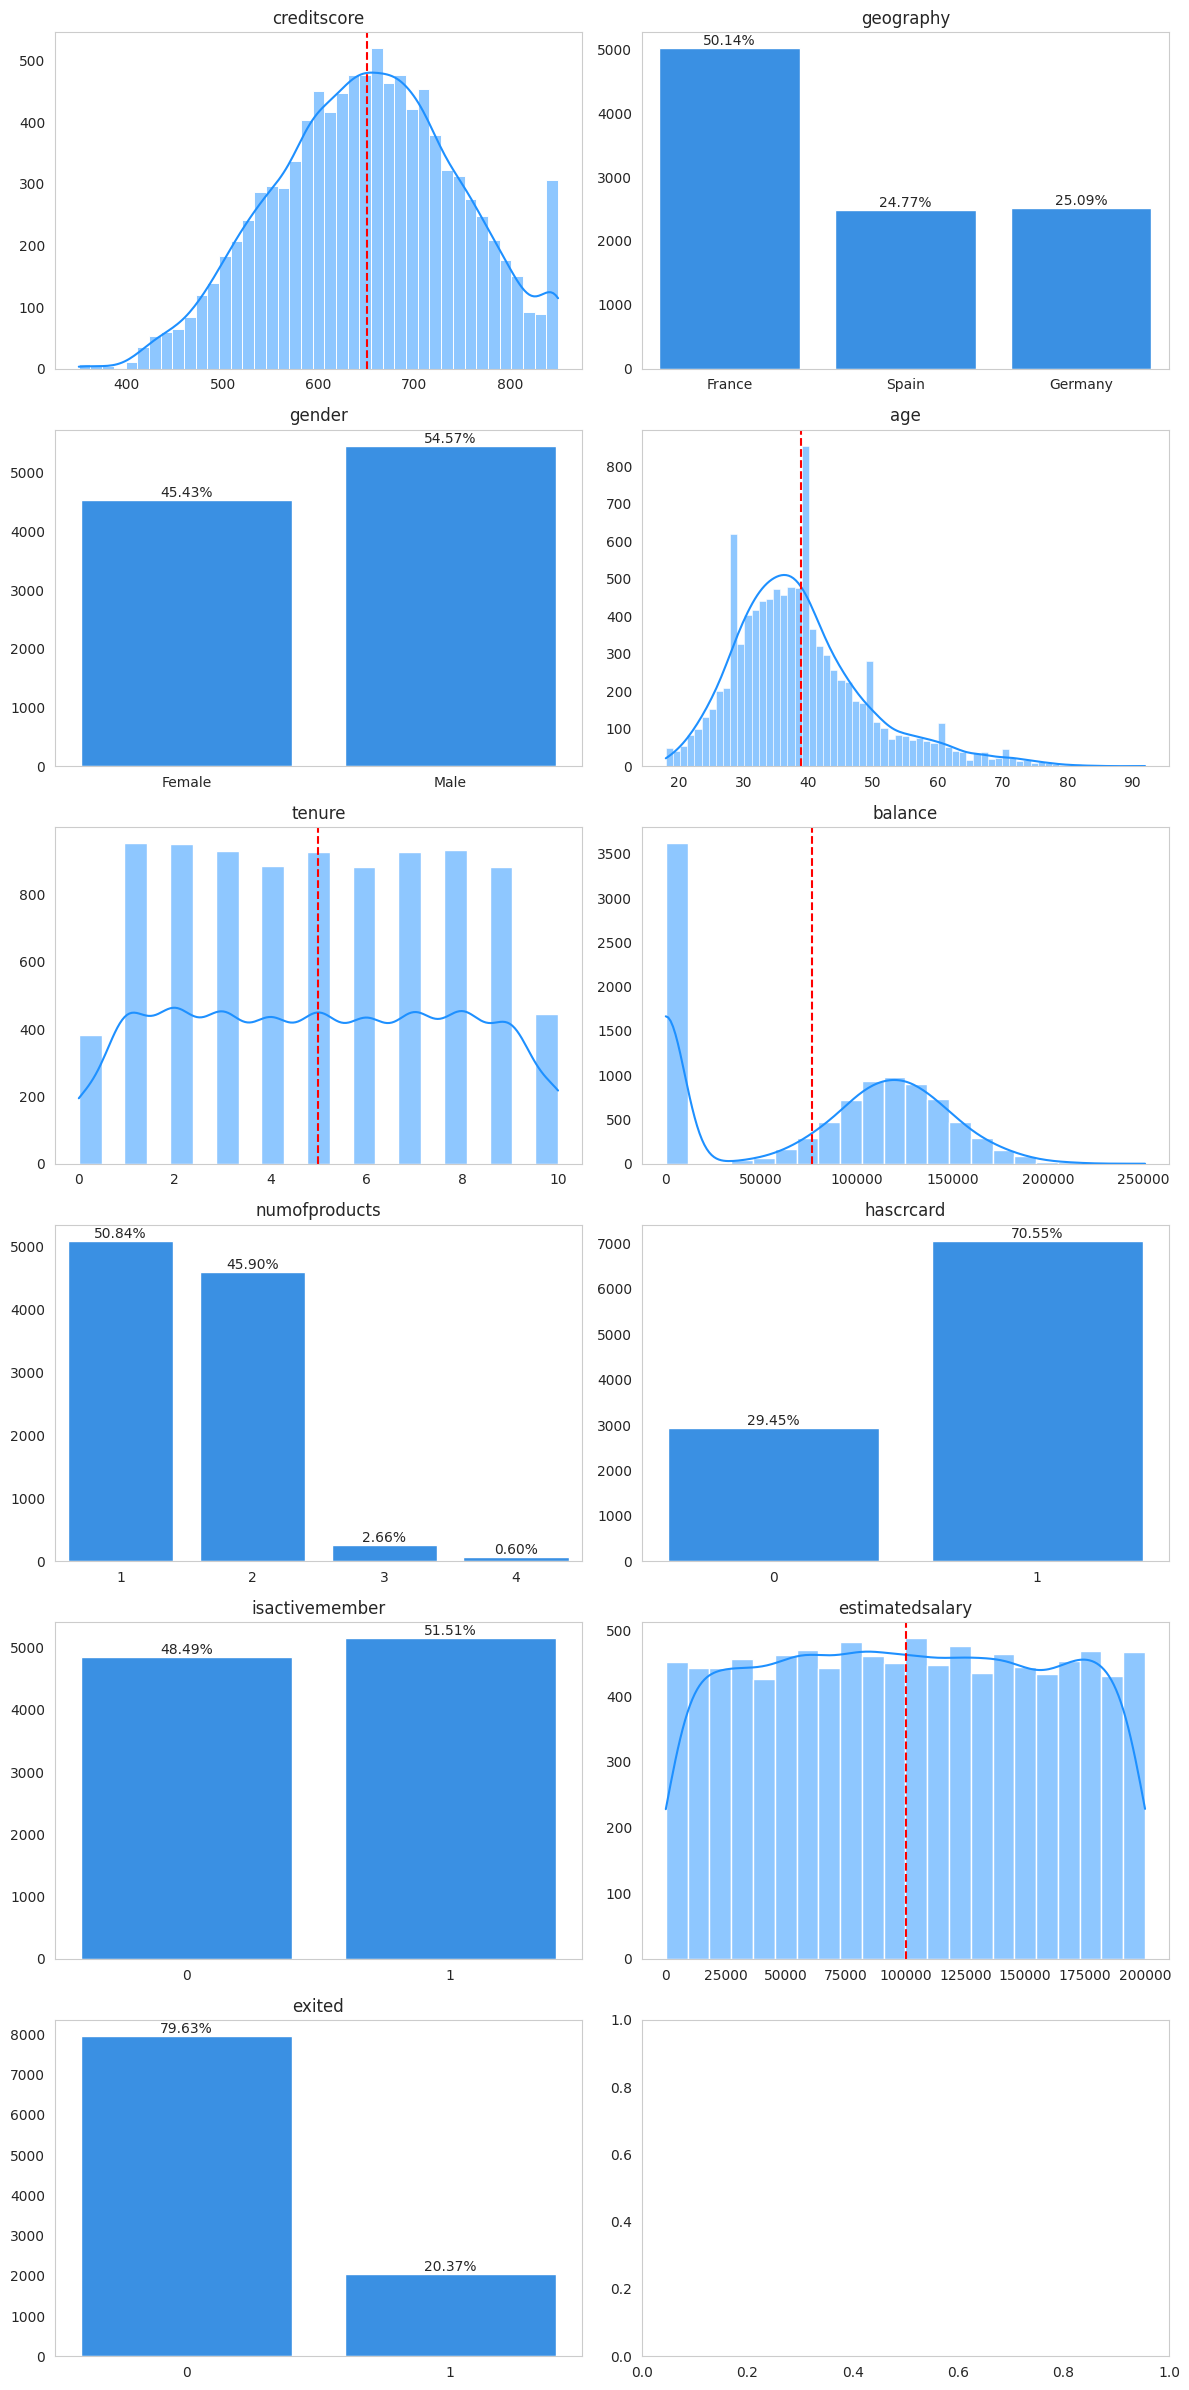

In [31]:
basic_data_preprocessing(df)

Summary:

Dataset Information:
The dataset consists of 10000 records and 11 columns.

Column Information:
- 'creditscore', 'age', 'balance', 'numofproducts', 'hascrcard', 'isactivemember', tenure', and 'exited' are numerical columns.
- 'geography' and 'gender' are categorical/object columns.

Missing Values:
The column 'tenure' has 909 missing values, while all other columns have no missing values.

Zero Values:
Some columns contain zero values:
- 'balance': 3617 occurrences of zero values.
- 'hascrcard': 2945 occurrences of zero values.
- 'isactivemember': 4849 occurrences of zero values.
- 'exited': 7963 occurrences of zero values.
In all of these columns, a value of 0 is theoretically possible, so no anomalies are observed.

No Duplicates: No duplicate records were found in the dataset.

No Negative Values: There are no negative values in the dataset.


Data Distribution:

- 'creditscore': The data tends to be normally distributed. However, there is a noticeable increase in the number of clients with a rating above 800;

- 'geography': The dataset consists of customers from France(50.14%), Spain(24.77%), Germany(25.09%).

- 'gender': The dataset shows a distribution close to balanced. Female(45.43%), Male(54.57%);

- 'age': data is skewed to the right. There are strong spikes in the number of clients aged 30 and 40 years;

- 'tenure': The distribution is unknown due to the missing values. However, judging by the available information, the data tends to balance;

- 'balance': Skewed towards the right, with many customers having balances close to zero;

- 'numofproducts': The majority of customers have one(50.84%) or two(45.90%) products;

- 'hascrcard': The majority of customers(70.55%) have a credit card;

- 'isactivemember': The data is distributed evenly;

- 'estimatedsalary': No specific distribution information available;

- 'exited': Imbalanced class distribution, with the majority of customers remaining active(79.63%).




Judging by the distribution of the data, the 'gender' column can be removed;

lso, judging by column 'geography', we can try leaving only the value 'France' (1=True or 0=False), since Spain and Germany are in an equal share of the distribution at 25%. But the decision will be made after analyzing the correlations.

In [32]:
# Fill missing values in the 'tenure' column with the average grouped by age
df['tenure'] = df.groupby('age')['tenure'].transform(lambda x: x.fillna(x.mean()))

In [33]:
df = df.drop(columns=['gender'])

In [34]:
data_type_compression(df)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   creditscore      10000 non-null  int16  
 1   geography        10000 non-null  object 
 2   age              10000 non-null  int8   
 3   tenure           10000 non-null  float16
 4   balance          10000 non-null  float32
 5   numofproducts    10000 non-null  int8   
 6   hascrcard        10000 non-null  int8   
 7   isactivemember   10000 non-null  int8   
 8   estimatedsalary  10000 non-null  float32
 9   exited           10000 non-null  int8   
dtypes: float16(1), float32(2), int16(1), int8(5), object(1)
memory usage: 244.3+ KB


In [36]:
# Encode categorical features in both dataframes
df = pd.get_dummies(df, columns=['geography'],drop_first=True)

### Data distribution by target

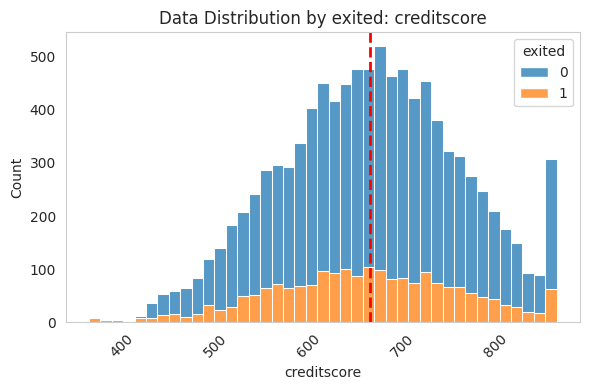

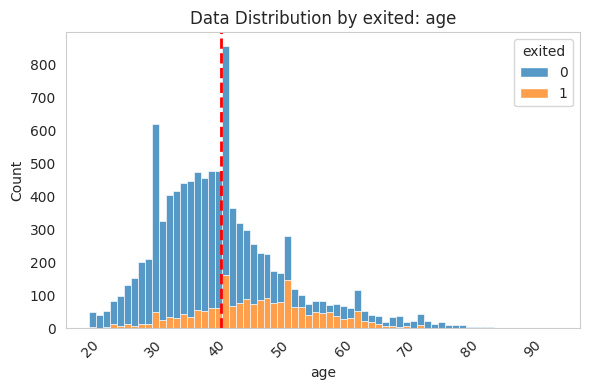

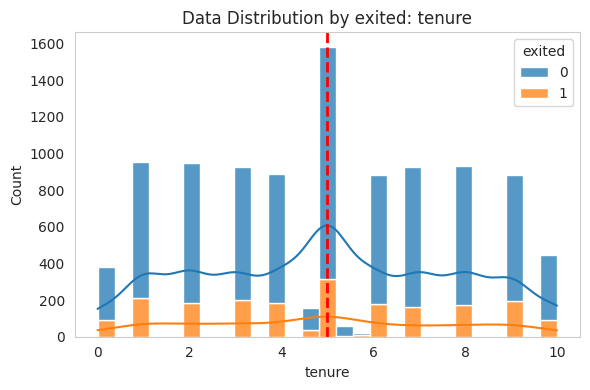

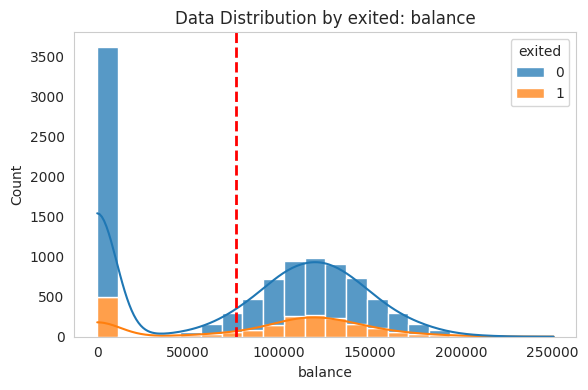

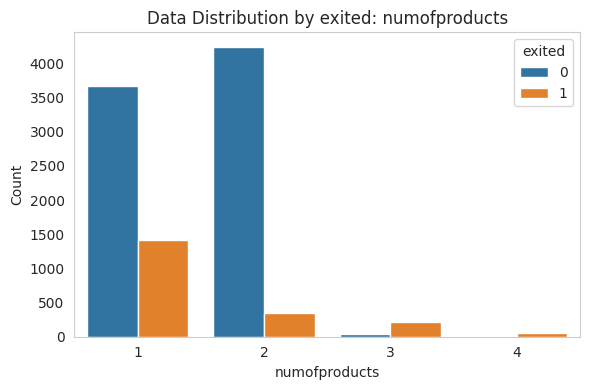

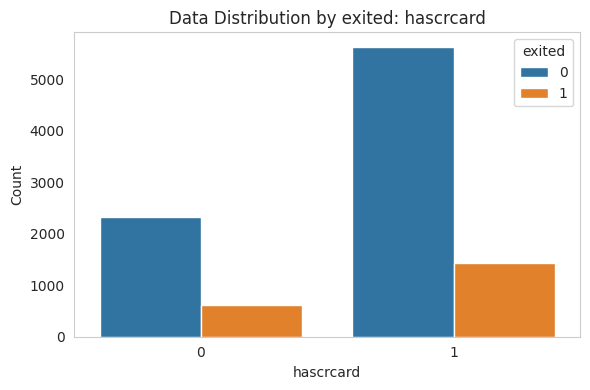

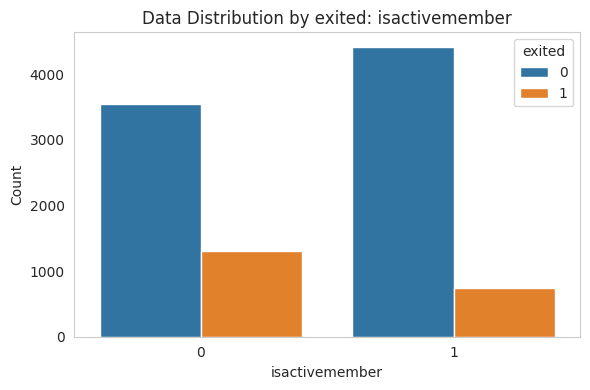

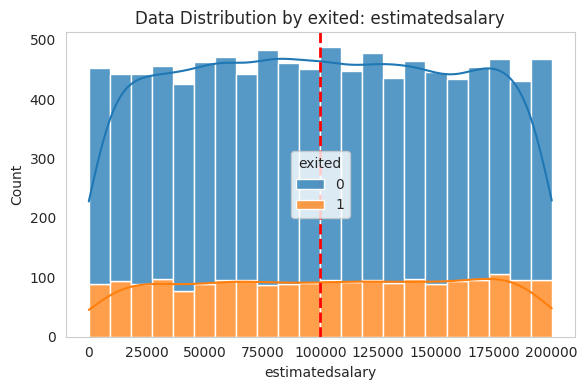

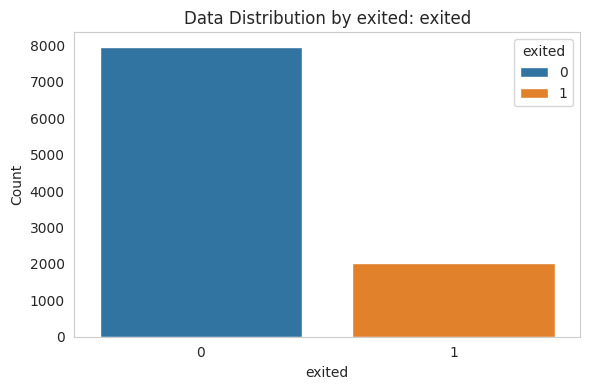

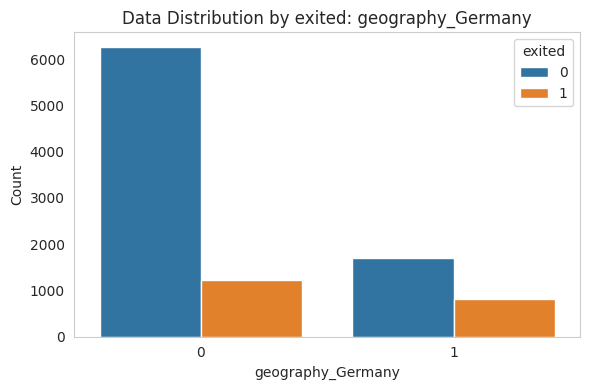

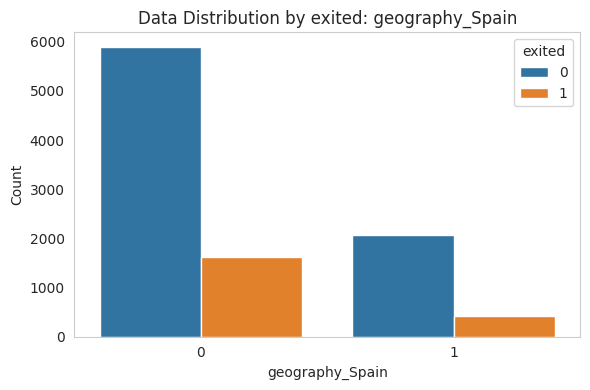

In [37]:
# dynamics of the target feature by other features
data_distribution_by_target(df, 'exited')

### Outliers

Outliers in column 'creditscore':
Outlier Count: 15
Outlier Percentage of total observations: 0.15%
Outlier Values: 376, 376, 363, 359, 350, 350, 358, 351, 365, 367, 350, 350, 382, 373, 350


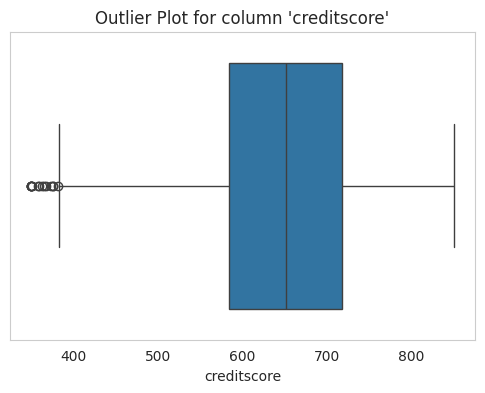

***************************************************************************

Outliers in column 'age':
Outlier Count: 359
Outlier Percentage of total observations: 3.59%
Outlier Values: 66, 75, 65, 73, 65, 72, 67, 67, 79, 80, 68, 75, 66, 66, 70, 63, 72, 64, 64, 70, 67, 82, 63, 69, 65, 69, 64, 65, 74, 67, 66, 67, 63, 70, 71, 72, 67, 74, 76, 66, 63, 66, 68, 67, 63, 71, 66, 69, 73, 65, 66, 64, 69, 64, 77, 74, 65, 70, 67, 69, 67, 74, 69, 74, 74, 64, 63, 63, 70, 74, 65, 72, 77, 66, 65, 74, 88, 63, 71, 63, 64, 67, 70, 68, 72, 71, 66, 75, 67, 73, 69, 76, 63, 85, 67, 74, 76, 66, 69, 66, 72, 63, 71, 63, 74, 67, 72, 72, 66, 84, 71, 66, 63, 74, 69, 84, 67, 64, 68, 66, 77, 70, 67, 79, 67, 76, 73, 66, 67, 64, 73, 76, 72, 64, 71, 63, 70, 65, 66, 65, 80, 66, 63, 63, 63, 63, 66, 74, 69, 63, 64, 76, 75, 68, 69, 77, 64, 66, 74, 71, 67, 68, 64, 68, 70, 64, 75, 66, 64, 78, 65, 74, 64, 64, 71, 77, 79, 70, 81, 64, 68, 68, 63, 79, 66, 64, 70, 69, 71, 72, 66, 68, 63, 71, 72, 72, 64, 78, 75, 65, 65, 67, 63, 68

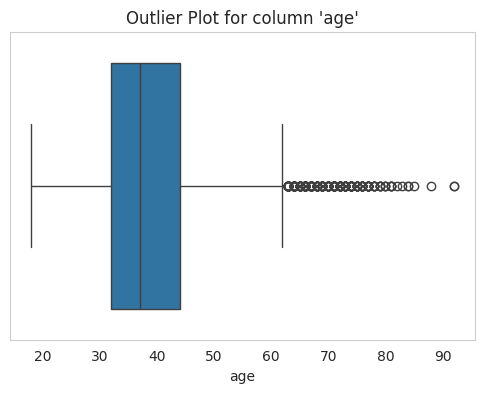

***************************************************************************

No outliers in column 'tenure'.
***************************************************************************

No outliers in column 'balance'.
***************************************************************************

Outliers in column 'numofproducts':
Outlier Count: 60
Outlier Percentage of total observations: 0.60%
Outlier Values: 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4


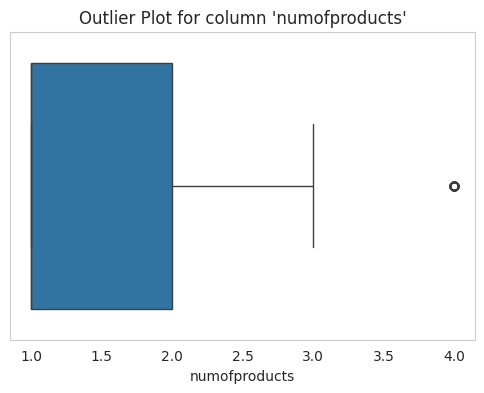

***************************************************************************

No outliers in column 'hascrcard' as it has binary values.
***************************************************************************

No outliers in column 'isactivemember' as it has binary values.
***************************************************************************

No outliers in column 'estimatedsalary'.
***************************************************************************

No outliers in column 'exited' as it has binary values.
***************************************************************************

No outliers in column 'geography_Germany' as it has binary values.
***************************************************************************

No outliers in column 'geography_Spain' as it has binary values.
***************************************************************************



,Column,Outlier Count,Outlier Percentage
0,creditscore,15,0.15
1,age,359,3.59
2,tenure,0,0.0
3,balance,0,0.0
4,numofproducts,60,0.6
5,hascrcard,NaN,NaN
6,isactivemember,NaN,NaN
7,estimatedsalary,0,0
8,exited,NaN,NaN
9,geography_Germany,NaN,NaN


In [38]:
detect_outliers(df)

The analysis results show that some columns contain outliers:

- Column 'age' has 359 outliers, which is approximately 3.59% of the total number of records.
- Column 'numofproducts' has 60 outliers, which is approximately 0.6% of the total number of records.

However, the percentage of outliers is small and therefore they will probably not have a significant impact on the overall performance of the models.

### Correlation

<ipython-input-5-4d96b245bba4>:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=75)
<ipython-input-5-4d96b245bba4>:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=75)


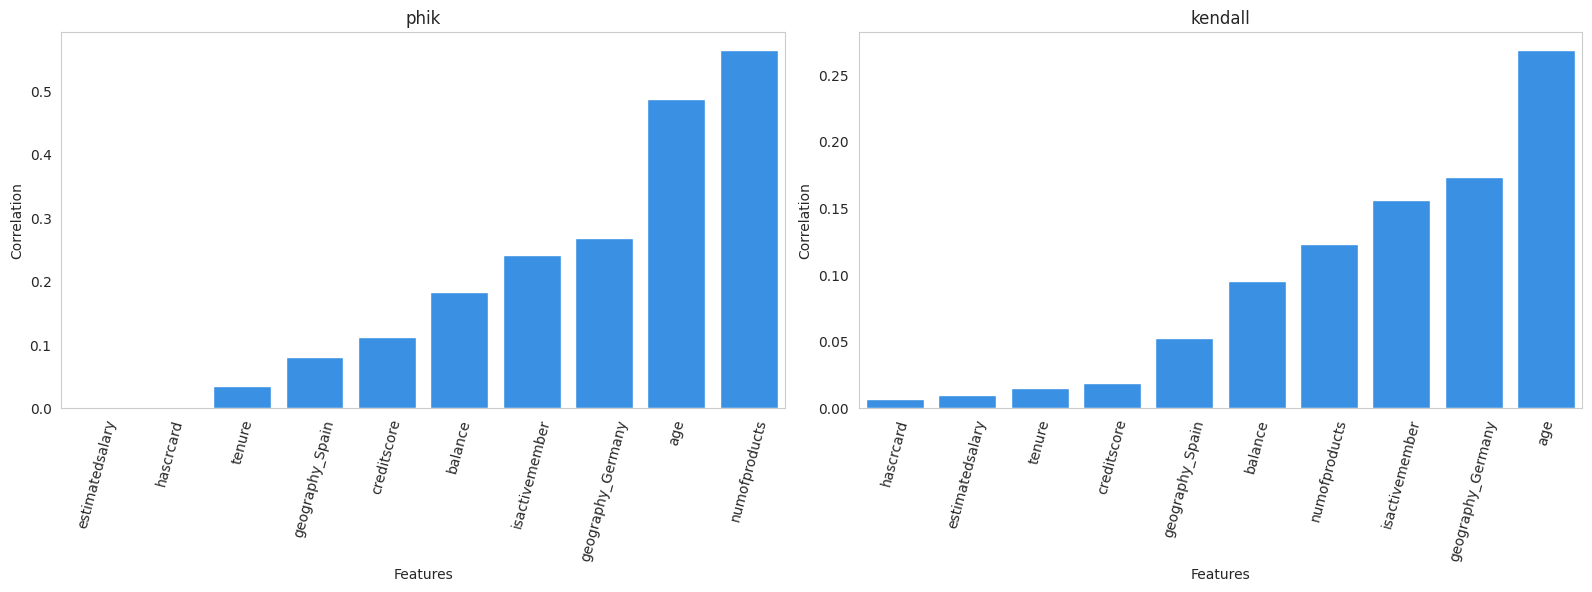

Correlation table with target feature 'exited':


Correlation Type,phik,kendall
Column,,
numofproducts,0.565084,0.123434
age,0.487170,0.268573
geography_Germany,0.268297,0.173488
isactivemember,0.241939,0.156128
balance,0.183365,0.094983
creditscore,0.112267,0.019049
geography_Spain,0.080682,0.052667
tenure,0.034990,0.015132
estimatedsalary,0.000000,0.009864



Top 2 features with highest correlation (Phik): ['numofproducts', 'age']

Top 2 features with highest correlation (Kendall): ['age', 'geography_Germany']


In [39]:
correlation_types=['phik', 'kendall']
correlation_analysis(df, 'exited', correlation_types=correlation_types, apply_abs=True)

The results of the correlation analysis for the given data are as follows:

1. According to the 'phi-k' correlation, the features 'numofproducts' (0.565084) and 'age' (0.487170) show the highest correlation with the target feature ('churn'). This suggests that customers with a higher number of products and older age are more not likely to churn.

2. The feature 'geography_Germany' (0.268297) also exhibits a moderate correlation with churn, indicating that customers from Germany are more likely to churn compared to other countries.

3. The features 'isactivemember' (0.241939) and 'balance' (0.183365) show relatively weaker correlations with churn.

4. The features 'geography_France' (0.163000), 'creditscore' (0.112267), and 'geography_Spain' (0.080682) demonstrate even weaker correlations with churn.

5. The features 'tenure', 'estimatedsalary', and 'hascrcard' show no correlation with the target variable.

Based on these results, it can be concluded that the number of products, age, and geography (specifically Germany) are the most important factors in predicting churn.

---

Checking for multicollinear features

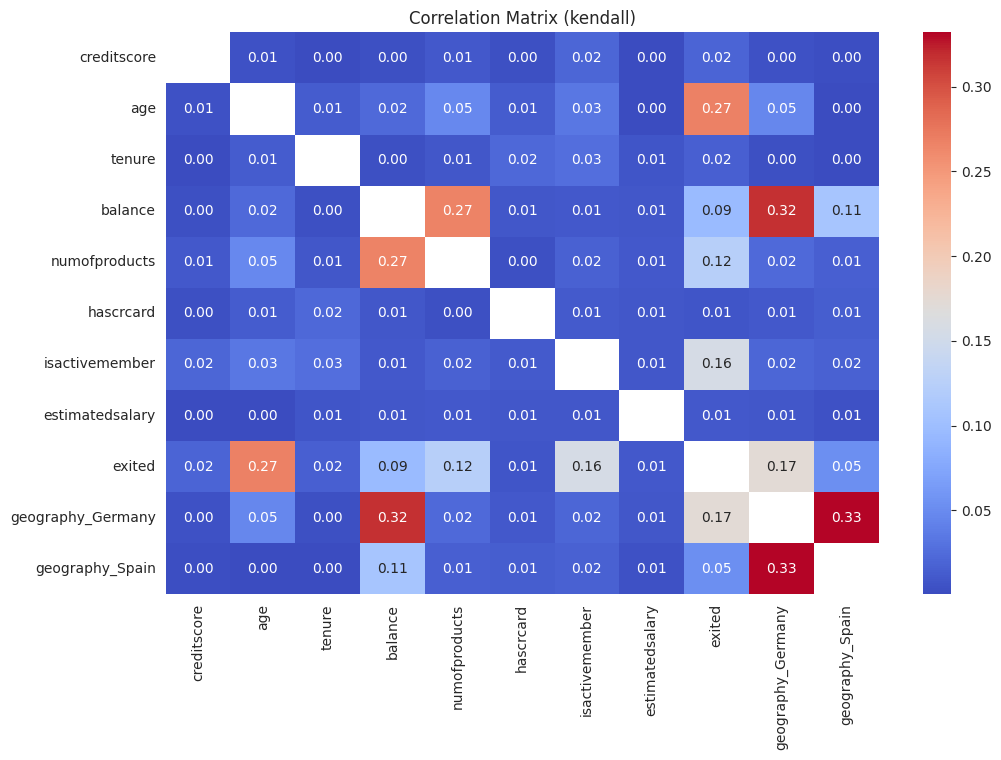

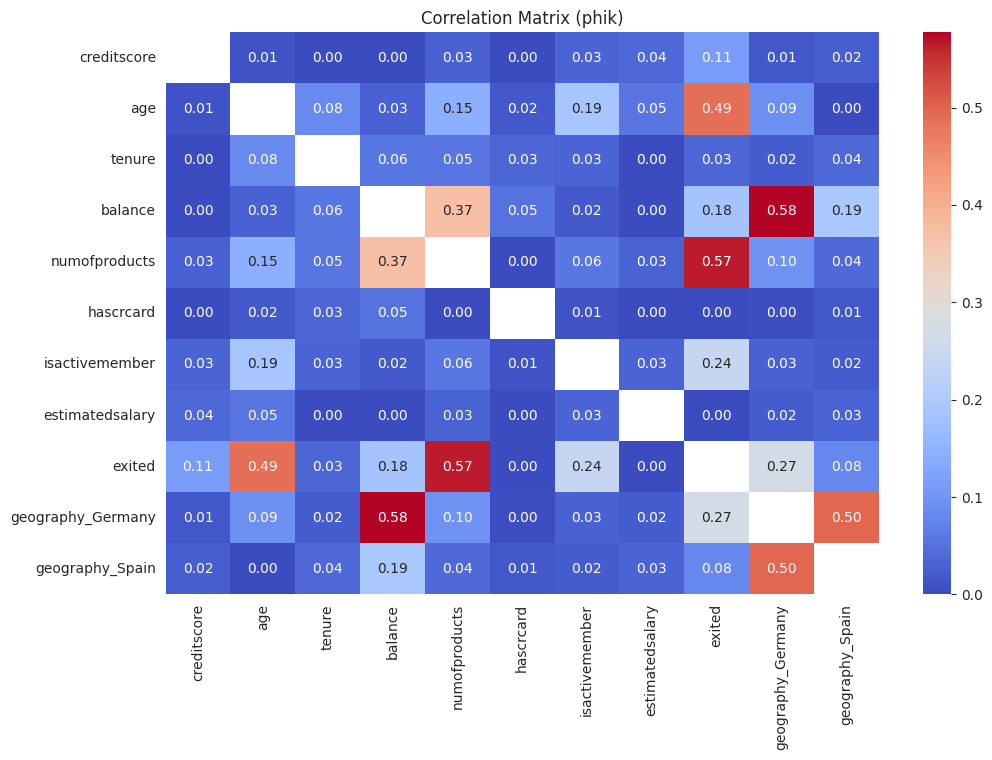


No features with high multicollinearity!


In [40]:
methods = ['kendall', 'phik']
find_multicollinearity(df, methods=methods, threshold=0.7)

No special multi-correlation connections were identified, except for connections based on geography.

## Model Training

In [41]:
import sklearn
from sklearn import linear_model
from sklearn import metrics
from sklearn import model_selection
from sklearn import tree

In [42]:
# Сreate a dataframe for storing trained models results

models_df = pd.DataFrame(columns=['Model', 'Recall', 'Training time', 'Special model parameters'])

In [43]:
df.head(3)

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_Germany,geography_Spain
0,619,42,2.0,0.000000,1,1,1,101348.882812,1,0,0
1,608,41,1.0,83807.859375,1,0,1,112542.578125,0,0,1
2,502,42,8.0,159660.796875,3,1,0,113931.570312,1,0,0


In [44]:
X = df.drop('exited', axis=1)
y = df['exited']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True)
X.head(3)

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_Germany,geography_Spain
0,619,42,2.0,0.000000,1,1,1,101348.882812,0,0
1,608,41,1.0,83807.859375,1,0,1,112542.578125,0,1
2,502,42,8.0,159660.796875,3,1,0,113931.570312,0,0


Next, let's standardize the data to ensure comparable scales and statistical properties across different features, leading to improved performance and generalizability of machine learning models.

In [45]:
from sklearn.preprocessing import StandardScaler

# Create an instance of StandardScaler
scaler = StandardScaler()

# Standardize the training data
X_train_scaled = scaler.fit_transform(X_train)

# Standardize the test data
X_test_scaled = scaler.transform(X_test)

### Baseline models

#### LogisticRegression

In [46]:
from sklearn.linear_model import LogisticRegression

# Create a pipeline with StandardScaler for LogisticRegression
lr_base = LogisticRegression(random_state=42)

#Cross-validation to evaluate the model
y_train_predict = model_selection.cross_val_predict(estimator=lr_base, X=X_train, y=y_train, cv=5)
y_test_predict = model_selection.cross_val_predict(estimator=lr_base, X=X_test, y=y_test, cv=5)

# Calculate the recall score
recall_train = metrics.recall_score(y_train, y_train_predict)
recall_test = metrics.recall_score(y_test, y_test_predict)

# Use cross_validate to perform cross-validation and get scores for multiple metrics
scores = model_selection.cross_validate(lr_base, X_train, y_train, cv=5, scoring='recall', return_train_score=True)

# Calculate the average fit time across different cross-validation folds
fit_time_mean = round(np.mean(scores['fit_time']), 2)


print(f"Average fit time: {fit_time_mean} seconds")
print('-' * 40)
print(f"Train Recall: {recall_train}")
print(f"Test Recall: {recall_test}")

Average fit time: 0.04 seconds
----------------------------------------
Train Recall: 0.053246753246753244
Test Recall: 0.05432595573440644


In [47]:
# Create a temporary dataframe with trained models results
temp_df = pd.DataFrame({'Model': ['lr_base'],
                        'Recall': [recall_test],
                        'Training time': [fit_time_mean],
                        })
models_df = pd.concat([models_df, temp_df], ignore_index=True)

models_df

,Model,Recall,Training time,Special model parameters
0,lr_base,0.054326,0.04,NaN


#### GradientBoostingClassifier

In [48]:
from sklearn.ensemble import GradientBoostingClassifier

gb_base =  GradientBoostingClassifier(random_state=42)

#Cross-validation to evaluate the model
y_train_predict = model_selection.cross_val_predict(estimator=gb_base, X=X_train, y=y_train, cv=5)
y_test_predict = model_selection.cross_val_predict(estimator=gb_base, X=X_test, y=y_test, cv=5)

# Calculate the recall score
recall_train = metrics.recall_score(y_train, y_train_predict)
recall_test = metrics.recall_score(y_test, y_test_predict)

# Use cross_validate to perform cross-validation and get scores for multiple metrics
scores = model_selection.cross_validate(gb_base, X_train, y_train, cv=5, scoring='recall', return_train_score=True)

# Calculate the average fit time across different cross-validation folds
fit_time_mean = round(np.mean(scores['fit_time']), 2)


print(f"Average fit time: {fit_time_mean} seconds")
print('-' * 40)
print(f"Train Recall: {recall_train}")
print(f"Test Recall: {recall_test}")

Average fit time: 1.46 seconds
----------------------------------------
Train Recall: 0.4623376623376623
Test Recall: 0.4567404426559356


In [49]:
# Create a temporary dataframe with trained models results
temp_df = pd.DataFrame({'Model': ['gb_base'],
                        'Recall': [recall_test],
                        'Training time': [fit_time_mean],
                        })
models_df = pd.concat([models_df, temp_df], ignore_index=True)

models_df

,Model,Recall,Training time,Special model parameters
0,lr_base,0.054326,0.04,NaN
1,gb_base,0.456740,1.46,NaN
